In [133]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [134]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [135]:
NUM_CLASSES = 7

# 学習データ読み込み

In [136]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [137]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [139]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [140]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_12 (Dropout)        (None, 42)                0         
                                                                 
 dense_18 (Dense)            (None, 20)                860       
                                                                 
 dropout_13 (Dropout)        (None, 20)                0         
                                                                 
 dense_19 (Dense)            (None, 10)                210       
                                                                 
 dense_20 (Dense)            (None, 7)                 77        
                                                                 
Total params: 1147 (4.48 KB)
Trainable params: 1147 (4.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [141]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [142]:
# モデルコンパイル
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

# モデル訓練

In [143]:
    model.fit(
        X_train,
        y_train,
        epochs=1000,
        batch_size=128,
        validation_data=(X_test, y_test),
        callbacks=[cp_callback, es_callback]
    )

Epoch 1/1000
 1/13 [=>............................] - ETA: 15s - loss: 2.3685 - accuracy: 0.0703
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
13/13 [==============================] - 2s 36ms/step - loss: 2.2090 - accuracy: 0.1096 - val_loss: 1.9908 - val_accuracy: 0.3075
Epoch 2/1000
12/13 [==========================>...] - ETA: 0s - loss: 1.9637 - accuracy: 0.2031

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
13/13 [==============================] - 0s 24ms/step - loss: 1.9648 - accuracy: 0.2025 - val_loss: 1.7720 - val_accuracy: 0.3075
Epoch 3/1000
10/13 [======================>.......] - ETA: 0s - loss: 1.7938 - accuracy: 0.2758
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
13/13 [==============================] - 0s 16ms/step - loss: 1.7806 - accuracy: 0.2824 - val_loss: 1.6112 - val_accuracy: 0.3230
Epoch 4/1000
12/13 [==========================>...] - ETA: 0s - loss: 1.6508 - accuracy: 0.3685
Epoch 4: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
13/13 [==============================] - 0s 14ms/step - loss: 1.6480 - accuracy: 0.3694 - val_loss: 1.4753 - val_accuracy: 0.4797
Epoch 5/1000
 1/13 [=>............................] - ETA: 0s - loss: 1.5757 - accuracy: 0.4688
Epoch 5: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
13/13 [==========

In [144]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

5/5 [==============================] - 0s 5ms/step - loss: 0.0247 - accuracy: 0.9981


In [145]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [146]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 146ms/step
[1.3579443e-04 5.2985095e-05 9.9515569e-01 2.5117683e-06 8.4468629e-05
 1.2454442e-05 4.5560044e-03]
2


# 混同行列

17/17 [==============================] - 0s 2ms/step


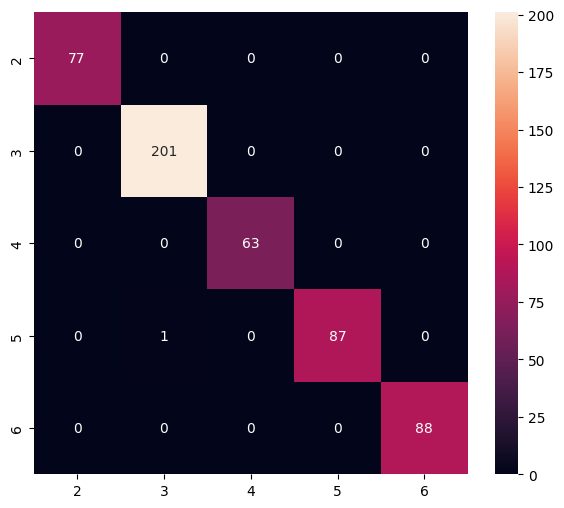

Classification Report
              precision    recall  f1-score   support

           2       1.00      1.00      1.00        77
           3       1.00      1.00      1.00       201
           4       1.00      1.00      1.00        63
           5       1.00      0.99      0.99        88
           6       1.00      1.00      1.00        88

    accuracy                           1.00       517
   macro avg       1.00      1.00      1.00       517
weighted avg       1.00      1.00      1.00       517



In [147]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [148]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [149]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpdj102axb\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpdj102axb\assets


6740

# 推論テスト

In [150]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [151]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [152]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [153]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [154]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.3579430e-04 5.2985095e-05 9.9515581e-01 2.5117686e-06 8.4468644e-05
 1.2454431e-05 4.5560091e-03]
2
